<a href="https://colab.research.google.com/github/frank-895/machine_learning_journey/blob/main/titanic_dataset/using_framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install fastbook

In [2]:
import pandas as pd, fastai, numpy as np
from fastai.tabular.all import *

# Using a Framework on the Titanic Dataset

## Introduction

In the previous notebook we manually built a deep learning (DL) model to demonstrate the specifics of how neural networks (NNs) work. However, in practice and when not learning, building NNs from scratch is generally time-consuming and will yield worse results. By using pre-made architectures and pretrained models, we can get better results as the models have been optimised by experts and with extensive research.

In this notebook, we will be using fastai to reproduce the results of the last notebook, where we create a model that predicts whether a person survived the Titanic disaster. We will also employ a more advanced technique called ensembling to improve on our model further.

## Prepare Data

In [3]:
df = pd.read_csv('train.csv')

In the last notebook, because we were building the NN from scratch, we had to carefully feature engineer as the variables all required a lot of work to prepare for the model. However, since we are using fastai, all of this is done for us! So, we will use some amazing features from this notebook [Titanic - Advanced Feature Engineering Tutorial](https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial/) to better understand Pandas and to improve our model.

The feature will be shown in code and explained *afterwards*.

In [4]:
df['LogFare'] = np.log1p(df.Fare)

`log1p` is a function that takes the logarithm of `Fare + 1`. Instead of having to add 1, to prevent `log(0)` this function does that for us!

We use the 'LogFare' as this column has many really big values and lots of smaller values. This can cause a skewed distribution - generally, machine learning (ML) models work better with more normal distributions.

In [5]:
df['Deck'] = df.Cabin.str[0].map(dict(A='ABC', B='ABC', C='ABC', D='DE', E='DE', F='FG', G='FG'))

`df.Cabin.str[0]` extracts the first letter of the 'Cabin' column, which represents the deck where the passenger's cabin is locate. We use `map` to group certain decks together.

This line reduces the number of unique categories and may improve the predictive power by simplifying the model's input data.

In [6]:
df['Family'] = df.SibSp + df.Parch

The 'Family' column is created by adding siblings and spouses and parents and children.

This column indicates that the sum of family members on board could be a predictor of a passenger's likelihood of survival.

In [7]:
df['Alone'] = df.Family == 0

Similar to above, this line indicates that travelling alone is a predictor of survival. This will produce a boolean value that fastai can automatically handle.

In [8]:
df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')

'TicketFreq' represents how many passesngers shared a ticket number. `groupby` allows us to treat all rows with the same ticket number as a group so we can perform operations on these groups. `transform` is applied after grouping and is used to count the occurences of each ticket number.

`transform` is very useful for performing calculations within groups while retaining the original shape of the DataFrame.

This feature indicates that people travelling on the same ticket may have had a similar experience during the journey impacting their likelihood of survival.

In [9]:
df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df['Title'] = df.Title.map(dict(Mr='Mr', Miss='Miss', Mrs='Mrs', Master='Master'))

The first line takes the common format of each name to extract the Title and save it into the DataFrame. Each name has the format:
```
Surname, Title. Name
```

The second line maps the four valid titles (for the purposes of this model). This will remove titles such as 'Dr' or 'Rev' in case of invalid titles and replace them with `NaN`.

This feature indicates that a person's title, which is indicative of their age, gender and family status, is a predictor of their likelihood of survival.

We can inspect our final dataframe below with many added features to optimise our model. Also note, their has been no need to convert values into specific types or deal with `NaN` values as fastai will do all this for us!

In [10]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,Deck,Family,Alone,TicketFreq,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2.110213,NaN,1,False,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C,4.280593,ABC,1,False,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2.188856,NaN,0,True,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3.990834,ABC,1,False,2,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,2.202765,NaN,0,True,1,Mr


We will put all of above into a function, so that we can also call it on the test data.

In [11]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))

Now, we can split the data using the methods provided by fastai and load our data into `TabularPandas` which works with well... Tabular data from Pandas!

In [12]:
splits = RandomSplitter(seed=42)(df) # like this last time, we will use a random split
splits

((#713) [788,525,821,253,374,98,215,313,281,305,701,812,76,50,387,47,516,564,434,117...],
 (#178) [303,778,531,385,134,476,691,443,386,128,579,65,869,359,202,187,456,880,705,797...])

In [13]:
%%capture
dls = TabularPandas(df,
                    splits = splits,
                    procs = [Categorify, FillMissing, Normalize],
                    cat_names = ["Sex","Pclass","Embarked","Deck", "Title"],
                    cont_names = ['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
                    y_names = "Survived",
                    y_block = CategoryBlock()
).dataloaders(path='.')

- `splits` defines the indices of the training and validation sets.
- `procs` turns strings to categories, fills missing values with the median and nomralises numeric columns.
- `cat_names` are the categorical variables.
- `cont_names` are the continuous variables.
- `y_names` is dependent variable.
- `y_block` defines the dependent variable as categorical, so we build a classification model not a regression model.

`dataloaders` batches the data and applies any necessary transformations. `path` is where any temporary files or processed data will be saved.

## Training the Model

Now that we have our `dataloaders` object it is *very* easy to create our model. We will make a `Learner` which is the data and the model (in this case, `tabular_learner` - it will pick us a good one!). While we don't strictly have to define the `layers`, we can and we will. This means it will be the same as the last notebook, when we had 2 hidden layers with 10 activations each. We also give it the `dataloaders` object and any metrics we want it to print on the way.

In [14]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

We can also use some fastai's advanced features to help us select a learning rate, which would ordinarily take experimentation.

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(slide=0.10000000149011612, valley=0.013182567432522774)

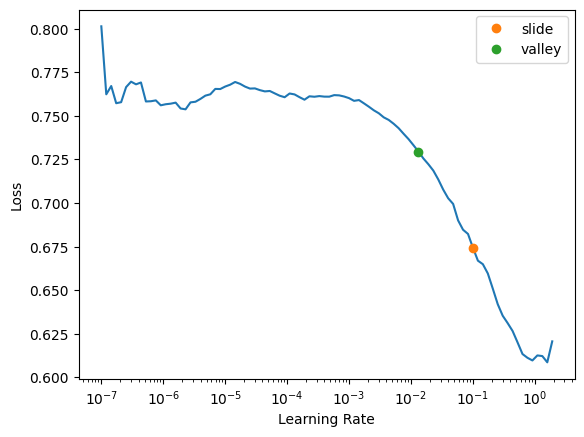

In [15]:
learn.lr_find(suggest_funcs=(slide, valley))

A good recommendation is to choose a value between slide and valley. In this case, we will use 0.001.

In [16]:
learn.fit(5, lr=0.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.732859,0.705296,0.460674,00:00
1,0.704238,0.697701,0.477528,00:00
2,0.690561,0.677158,0.494382,00:00
3,0.675492,0.654067,0.668539,00:00
4,0.657948,0.622865,0.719101,00:00


We have achieved a similar accuracy to our 'from-scratch' model at `0.848`! This is expected, considering the dataset is small and a simple linear model was already working very well. Let's use some more advanced techniques to improve this - even just a little bit.

## Ensembling

**Ensembling** is the process of creating several separate models, each trained from different random starting points, and averaging their predictions. Since its very easy to make 1 model, making 5 will not be hard either!

We use `learn.no_bar()` and `learn.no_logging()` to supress the training output for cleaner execution.

We use `[0]` as `get_preds()` also outputs target labels, which we don't need.

In [17]:
def ensemble():
  learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
  with learn.no_bar(), learn.no_logging():
    learn.fit(5, lr=0.001)
  return learn.get_preds(dl=tst_dl)[0]

Let's prepare our test data so that we can generate predictions using ensembling. While we do need to apply the same feature engineering to the test dataframe, all the preprocessing steps for the data are saved in the `Learner` so we can pass it directly in usin `test_dl()` so it applies those steps.

In [18]:
%%capture
tst_df = pd.read_csv('test.csv')
tst_df['Fare'] = tst_df.Fare.fillna(0) # account for some missing columns in the dataset
add_features(tst_df)

tst_dl = learn.dls.test_dl(tst_df)

Now we can call our `ensemble()` function 5 times, collecting the results into a list. As you can see, the learns will contain 5 tensors, each with the probability that the person survived and the probability they did not - for each learner model.

In [19]:
learns = [ensemble() for _ in range(5)]
learns[0][:5]

tensor([[0.7815, 0.2185],
        [0.5938, 0.4062],
        [0.7885, 0.2115],
        [0.7729, 0.2271],
        [0.5291, 0.4709]])

Using PyTorch, we will stack these preditions and take the mean across the 0th dimension. The 0th dimensions represents the number of models, the 1st dimension represents the number of predictions made for each model, and the 2nd dimension represents the number of categories.

By averaging across the 0th dimension (the 5 different model), these represent our **final predictions**!

In [20]:
preds = torch.stack(learns)
print(preds.shape)
preds = preds.mean(0)
preds[:5]

torch.Size([5, 418, 2])


tensor([[0.7327, 0.2673],
        [0.6084, 0.3916],
        [0.7272, 0.2728],
        [0.7256, 0.2744],
        [0.4610, 0.5390]])

If we wanted to export this to submit to the Kaggle competition, we would use the following code:

In [21]:
tst_df['Survived'] = (preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('ens_sub.csv', index=False)

## Conclusion

We've learnt some advanced deep learning techniques to build an optimal model that can predict a person's survival of the Titanic based on statistics.

While this approach doesn't allow us to see the underlying code behind creating a model, it produces quicker and better results and makes use of the the extensive research and expertise that has gone into deep learning optimisation.